In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install chess

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import re
import numpy as np
import chess
import pandas as pd
import gc
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.4 MB/s eta 0:00:00a 0:00:01
/kaggle/input/chess-games/chess_games.csv


In [3]:
letter_2_num = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}
num_2_letter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h'}

In [4]:
import chess

# Create a chess board
board = chess.Board()

# Print the chess board in characters
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


**2.**

In [5]:
#making chess board layers
def create_rep_layer(board, type):

    s = str(board)
    s = re.sub(f'[^{type}{type.upper()} \n]', '.', s)   
    s = re.sub(f'{type}', '-1', s)
    s = re.sub(f'{type.upper()}', '1', s)
    s = re.sub(f'\.', '0', s)

    board_mat = []
    for row in s.split('\n'):
        row = row.split(' ')
        row = [int(x) for x in row]
        board_mat.append(row)
    
    return np.array(board_mat)

**1**

In [6]:
def board_2_rep(board):
    pieces = ['p', 'r', 'n', 'b', 'q', 'k']
    layers = []
    for piece in pieces:
        layers.append(create_rep_layer(board, piece))
    board_rep = np.stack(layers)
    return board_rep

In [7]:
#converting moves in a list form
def create_move_list(s):
    return re.sub('\d*\. ','',s).split(' ')[:-1]

In [8]:
#single move ki representation
def move_2_rep(move, board):
    board.push_san(move).uci()
    move = str(board.pop())

    from_output_layer = np.zeros((8,8))
    from_row = 8 - int(move[1])
    from_column = letter_2_num[move[0]]
    from_output_layer[from_row, from_column] = 1

    to_output_layer = np.zeros((8,8))
    to_row = 8 - int(move[3])
    tow_column = letter_2_num[move[2]]
    to_output_layer[to_row, tow_column] = 1

    return np.stack([from_output_layer, to_output_layer])

In [9]:
chess_data_raw = pd.read_csv('/kaggle/input/chess-games/chess_games.csv', usecols = ['AN', 'WhiteElo'])
chess_data = chess_data_raw[chess_data_raw['WhiteElo'] > 2500]
del chess_data_raw
gc.collect
chess_data = chess_data[['AN']]
chess_data = chess_data[~chess_data['AN'].str.contains('{')]
chess_data = chess_data[chess_data['AN'].str.len() > 20]
print(chess_data.shape[0])

15006


In [10]:
chess_data.head

<bound method NDFrame.head of                                                         AN
153      1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
482      1. e4 c5 2. Nf3 a6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
846      1. d4 Nf6 2. c4 e6 3. Nc3 d5 4. cxd5 exd5 5. B...
1420     1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. O-...
1448     1. Nf3 d6 2. d4 Bf5 3. c4 Nc6 4. d5 Nb4 5. Na3...
...                                                    ...
6253469  1. e4 c5 2. Nc3 d6 3. f4 e5 4. Nf3 Nc6 5. Bc4 ...
6253566  1. e4 d5 2. Nc3 d4 3. Nce2 c5 4. d3 Nc6 5. f4 ...
6253892  1. Nf3 Nf6 2. g3 e5 3. Bg2 e4 4. Nd4 d5 5. O-O...
6254174  1. e4 c5 2. Nf3 Nc6 3. Nc3 d6 4. d4 cxd4 5. Nx...
6254961  1. d4 Nf6 2. c4 c5 3. Nc3 cxd4 4. Qxd4 d6 5. Q...

[15006 rows x 1 columns]>

In [11]:
class ChessDataset(Dataset):

    def __init__(self, games):
        super(ChessDataset, self).__init__()
        self.games = games
    
    def __len__(self):
        return 25000
    
    def __getitem__(self, index):
        game_i = np.random.randint(self.games.shape[0])     #choosing random index
        random_game = chess_data['AN'].values[game_i]       # choose game on index
        moves = create_move_list(random_game)                #creating moves list in that random game
        game_state_i = np.random.randint(len(moves)-1)       #choosing random instance from that game
        next_move = moves[game_state_i]                      #that instance will be our target
        moves = moves[:game_state_i]                          #prevous all moves will be input
        board = chess.Board()                                #making a chess board (alphabet wala)
        for move in moves:                                    #saare moves ka board bnana hai ab
            board.push_san(move)                              #SAN notation me bna diya board ab usko matrix me convert karenge
        x = board_2_rep(board)
        y = move_2_rep(next_move, board)
        if game_state_i % 2 == 1:
            x*=-1

        return x, y                    # x = board before making the move         # y = jo move kiya hai uska previous position and current position

In [12]:
data_train = ChessDataset(chess_data['AN'])
data_train_loader = DataLoader(data_train, batch_size = 32, shuffle=True, drop_last=True)
print(data_train[0])

(array([[[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  0,  0,  1,  1,  1,  1],
        [ 0,  0,  1,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, -1, -1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, -1,  0],
        [-1, -1, -1,  0,  0, -1,  0, -1],
        [ 0,  0,  0,  0,  0,  0,  0,  0]],

       [[ 1,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  0,  0, -1]],

       [[ 0,  0,  0,  0,  0,  0,  1,  0],
        [ 0,  0,  0,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0, -1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 

In [13]:
class module(nn.Module):
    
    def __init__(self, hidden_size):
        super(module, self).__init__()
        self.conv1 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.bn2 = nn.BatchNorm2d(hidden_size)
        self.activation1 = nn.SELU()
        self.activation2 = nn.SELU()

    def forward(self, x):
        x_input = torch.clone(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += x_input
        x = self.activation2(x)
        return x

In [14]:
# import tensorflow as tf
# from tensorflow.keras import layers

# class Module(layers.Layer):
#     def __init__(self, hidden_size):
#         super(Module, self).__init__()
#         self.conv1 = layers.Conv2D(hidden_size, 3, padding='same')
#         self.conv2 = layers.Conv2D(hidden_size, 3, padding='same')
#         self.bn1 = layers.BatchNormalization()
#         self.bn2 = layers.BatchNormalization()
#         self.activation1 = layers.Activation('selu')
#         self.activation2 = layers.Activation('selu')

#     def call(self, inputs):
#         x_input = tf.identity(inputs)
#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = self.activation1(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x += x_input
#         x = self.activation2(x)
#         return x


In [15]:
# class ChessNet(tf.keras.Model):
#     def __init__(self, hidden_layers=4, hidden_size=200):
#         super(ChessNet, self).__init__()
#         self.hidden_layers = hidden_layers
#         self.input_layer = layers.Conv2D(hidden_size, 3, padding='same')
#         self.module_list = [Module(hidden_size) for _ in range(hidden_layers)]
#         self.output_layer = layers.Conv2D(2, 3, padding='same')

#     def call(self, inputs):
#         x = self.input_layer(inputs)
#         x = tf.nn.relu(x)

#         for i in range(self.hidden_layers):
#             x = self.module_listi

#         x = self.output_layer(x)

#         return x


In [16]:
class ChessNet(nn.Module):
    
    def __init__(self, hidden_layers=4, hidden_size=200):
        super(ChessNet, self).__init__()
        self.hidden_layers = hidden_layers
        self.input_layer = nn.Conv2d(6, hidden_size, 3, stride=1, padding=1)
        self.module_list = nn.ModuleList([module(hidden_size) for i in range(hidden_layers)])
        self.output_layer = nn.Conv2d(hidden_size, 2, 3, stride=1, padding=1)

    def forward(self, x):

        x = self.input_layer(x)
        x = F.relu(x)

        for i in range(self.hidden_layers):
            x = self.module_list[i](x)

        x = self.output_layer(x)

        return x

In [17]:
def checkmate_single(board):
    board = board.copy()
    legal_moves = list(board.legal_moves)
    for move in legal_moves:
        board.push_uci(str(move))
        if board.is_checkmate():
            move = board.pop()
            return move
        _ = board.pop()
    return None

In [18]:
#if pawn diagonally behind a piece(queen,rook,bishop). kill him

In [19]:
def distribution_over_moves(vals):
    probs = np.array(vals)
    probs = np.exp(probs)
    probs = probs / probs.sum()
    probs = probs ** 3
    probs = probs / probs.sum()
    return probs

In [20]:
def predict(x):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        return outputs.cpu().numpy()

In [33]:
def choose_move(board,color):

    legal_moves = list(board.legal_moves)

    move = checkmate_single(board)   #checking if single move me possible hai check mate

    if move is not None:   #if yes..kardo
        return move
    
    x = torch.Tensor(board_2_rep(board)).float().to('cuda')
    if color == chess.BLACK:
        x *= -1
    x = x.unsqueeze(0)
    move = predict(x)
    # print(move)
    vals = []
    froms = [str(legal_move)[:2] for legal_move in legal_moves]
    froms = list(set(froms))
    for from_ in froms:
        # print(move[0,:,:][0][0])
        val = move[0,:,:][0][8-int(from_[1]), letter_2_num[from_[0]]]
        # print(from_)
        vals.append(val)
    
    probs = distribution_over_moves(vals)

    chosen_from = str(np.random.choice(froms, size=1, p=probs)[0])[:2]

    vals = []
    for legal_move in legal_moves:
        from_ = str(legal_move)[:2]
        if from_ == chosen_from:
            to = str(legal_move)[2:]
            # print(move[0,:,:][0])
            # print(move[0,:,:][1])
            val = move[0,:,:][1][8 - int(to[1]), letter_2_num[to[0]]]
            vals.append(val)
        else:
            vals.append(0)
    chosen_move = legal_moves[np.argmax(vals)]
    return chosen_move

In [22]:
metric_from = nn.CrossEntropyLoss()
metric_to = nn.CrossEntropyLoss()

In [23]:
torch.cuda.is_available()           #checking if gpu is available

True

In [24]:
import torch.optim as optim

model = ChessNet(hidden_layers=4, hidden_size=200).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
record = []
num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(data_train_loader):
        inputs = inputs.float().to('cuda')  
        labels = labels.float().to('cuda')  # convert labels to float and using gpu
        optimizer.zero_grad()
        outputs = model(inputs)
        output_from = outputs[:, 0, :]
        output_to = outputs[:, 1, :]
        y_from = labels[:, 0, :]
        y_to = labels[:, 1, :]
        loss_from = nn.CrossEntropyLoss()(output_from, y_from.argmax(dim=1))   #computing loss of choosing move
        loss_to = nn.CrossEntropyLoss()(output_to, y_to.argmax(dim=1))          #loss for chossing next position
        loss = loss_from + loss_to
        loss.backward()                                       # back propagating
        optimizer.step()
        record.append(loss.item())
        if i % 1000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(data_train_loader), loss.item()))
    torch.save(model.state_dict(), '/kaggle/working/model.h5')

Epoch [1/10], Step [1/781], Loss: 4.7994
Epoch [2/10], Step [1/781], Loss: 0.6895
Epoch [3/10], Step [1/781], Loss: 0.6185
Epoch [4/10], Step [1/781], Loss: 0.6885
Epoch [5/10], Step [1/781], Loss: 0.6589
Epoch [6/10], Step [1/781], Loss: 0.6929
Epoch [7/10], Step [1/781], Loss: 0.7758
Epoch [8/10], Step [1/781], Loss: 0.6987
Epoch [9/10], Step [1/781], Loss: 0.6265
Epoch [10/10], Step [1/781], Loss: 0.6908


In [25]:
!pip install chess

In [26]:
import chess

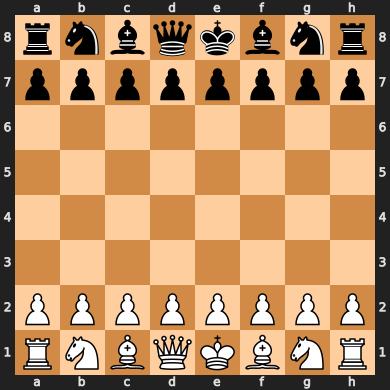

In [29]:
board = chess.Board()  #i can give fen string as input to make chess bot
board

bot moves :: 
h3g5


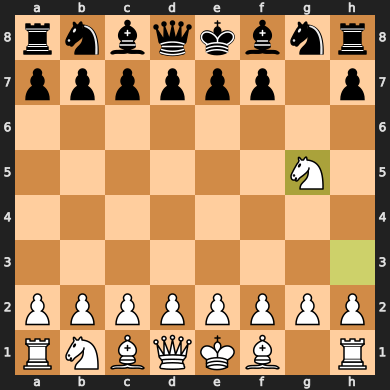

In [37]:
legal = choose_move(board,chess.BLACK)
print("bot moves :: ")
print(legal)
# If there are any legal moves, make the first one
board.push(legal)
board

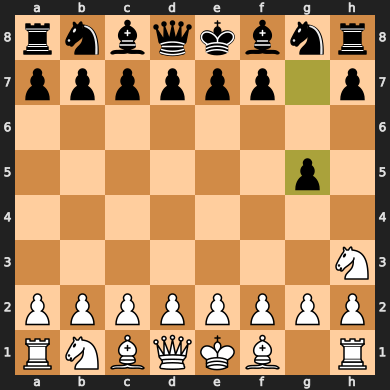

In [36]:
move = chess.Move.from_uci("g7g5")

if move in board.legal_moves:
    board.push(move)
else:
    print("Move is not legal")
board

In [ ]:
# model = ChessNet(hidden_layers=4, hidden_size=200)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# for epoch in range(num_epochs):
#     for i, (inputs, labels) in enumerate(data_train_loader):
#         inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
#         labels = tf.convert_to_tensor(labels, dtype=tf.float32)
#         with tf.GradientTape() as tape:
#             outputs = model(inputs)
#             output_from = outputs[:, 0, :]
#             output_to = outputs[:, 1, :]
#             y_from = labels[:, 0, :]
#             y_to = labels[:, 1, :]
#             loss_from = loss_fn(y_from, output_from)
#             loss_to = loss_fn(y_to, output_to)
#             loss = loss_from + loss_to
#         gradients = tape.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#         if i % 1000 == 0:
#             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(data_train_loader), loss))
#     model.save_weights('/kaggle/working/model.h5')
